In [1]:
import sys
import os
import requests
import datetime
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))

import time
import talib
import sqlite3 as sqlite3
import numpy as np
import pandas as pd
import json
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='DejaVuSansYuanTi-Regular.ttf')
from scipy import stats
from util.util import get_ucodes
from pypfopt import risk_models, expected_returns, efficient_frontier, plotting, objective_functions

path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')

cur_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
temp_path = os.path.join(path_root, '現代資產組合', cur_time)
Path(temp_path).mkdir(parents=True, exist_ok=True)

pd.options.mode.chained_assignment = None

In [2]:
# 繪圖
def draw_table(data, title, scale_x=2, scale_y=1.5, is_show=False):
    ax = plt.subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    table = pd.plotting.table(ax, data, loc='center')
    table.auto_set_column_width(col=list(range(len(data.columns))))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(scale_x, scale_y)
    plt.savefig(os.path.join(temp_path, title), bbox_inches="tight")
    if not is_show:
        plt.clf()
    print(title)

In [3]:
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()

data = {}
ucodes = ['hsi', 'hsce', 'ssec', 'ixic', 'sp500', 'n225', 'twii', 'ks11', 'gdaxi', 'fchi', 'ftse', 'shy', 'tlt', 'cclhk']
for ucode in ucodes:
    if '.HK' in ucode:
        ucode = ucode.replace('.HK', '').zfill(5)
    if '.SS' in ucode or '.SZ' in ucode:
        ucode = ucode.replace('.SS', '').replace('.SZ', '').zfill(6)
    
    #
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC) AS t 
                            ORDER BY t.stime """.format(ucode)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
    data[ucode].index = pd.to_datetime(data[ucode].sdate)
    print(f"{ucode}:   {data[ucode].index[0]} ~ {data[ucode].index[-1]}  {data[ucode].shape}")
conn.close()

hsi:   1986-12-31 00:00:00 ~ 2021-09-06 00:00:00  (8535, 9)
hsce:   1993-07-15 00:00:00 ~ 2021-09-06 00:00:00  (6898, 9)
ssec:   1992-05-08 00:00:00 ~ 2021-09-06 00:00:00  (7235, 9)
ixic:   1971-02-05 00:00:00 ~ 2021-09-06 00:00:00  (12404, 9)
sp500:   1927-12-30 00:00:00 ~ 2021-09-06 00:00:00  (19687, 9)
n225:   1965-01-05 00:00:00 ~ 2021-09-06 00:00:00  (13720, 9)
twii:   1990-01-04 00:00:00 ~ 2021-08-27 00:00:00  (7776, 9)
ks11:   1990-01-03 00:00:00 ~ 2021-09-06 00:00:00  (7813, 9)
gdaxi:   1987-12-30 00:00:00 ~ 2021-09-06 00:00:00  (8491, 9)
fchi:   1990-03-01 00:00:00 ~ 2021-09-06 00:00:00  (7995, 9)
ftse:   1984-01-03 00:00:00 ~ 2021-09-06 00:00:00  (9574, 9)
shy:   2002-07-30 00:00:00 ~ 2021-09-03 00:00:00  (4810, 9)
tlt:   2002-07-30 00:00:00 ~ 2021-09-03 00:00:00  (4810, 9)
cclhk:   1993-12-13 00:00:00 ~ 2021-08-30 00:00:00  (1446, 9)


In [4]:
data_all = []
nmll = []
for k, df in data.items():
    data_all.append(df['last'])
    nmll.append(k)
df2 = pd.concat(data_all, axis=1)
df2 = df2.dropna()
df2.columns = nmll
print(f"{df2.index[0]} ~ {df2.index[-1]}  {df2.shape}")

2002-08-05 00:00:00 ~ 2021-08-02 00:00:00  (621, 14)


In [5]:
start_year = list(dict.fromkeys(df2.index.year.values))[1]
end_year = list(dict.fromkeys(df2.index.year.values))[-1]

相關系數 2003年起
correlation_coefficient_2.png


,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,shy,tlt,cclhk
hsi,1.000000,0.857719,0.758172,0.700842,0.751819,0.725088,0.835585,0.923710,0.879599,0.697857,0.886801,0.818358,0.731382,0.849001
hsce,0.857719,1.000000,0.824185,0.329535,0.366345,0.355637,0.564020,0.753096,0.567752,0.443117,0.645265,0.684521,0.445625,0.545460
ssec,0.758172,0.824185,1.000000,0.440591,0.470542,0.508833,0.607563,0.668388,0.612606,0.553707,0.562172,0.577386,0.471102,0.518210
ixic,0.700842,0.329535,0.440591,1.000000,0.987022,0.890193,0.934899,0.791742,0.895655,0.666942,0.655127,0.740324,0.880217,0.862204
sp500,0.751819,0.366345,0.470542,0.987022,1.000000,0.930584,0.938179,0.813074,0.938574,0.738059,0.749646,0.738239,0.878956,0.890904
n225,0.725088,0.355637,0.508833,0.890193,0.930584,1.000000,0.867025,0.731813,0.898751,0.886484,0.783778,0.569741,0.727359,0.775653
twii,0.835585,0.564020,0.607563,0.934899,0.938179,0.867025,1.000000,0.905989,0.912035,0.747567,0.760838,0.768595,0.812972,0.839566
ks11,0.923710,0.753096,0.668388,0.791742,0.813074,0.731813,0.905989,1.000000,0.906622,0.636712,0.839271,0.882663,0.809849,0.875285
gdaxi,0.879599,0.567752,0.612606,0.895655,0.938574,0.898751,0.912035,0.906622,1.000000,0.752944,0.887427,0.831305,0.885356,0.947075
fchi,0.697857,0.443117,0.553707,0.666942,0.738059,0.886484,0.747567,0.636712,0.752944,1.000000,0.795584,0.362629,0.465500,0.554312


<Figure size 432x288 with 0 Axes>

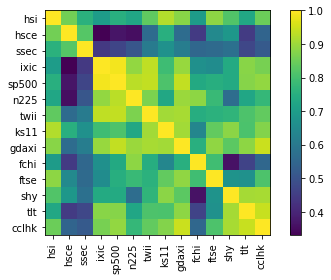

In [6]:
# 相關系數
print(f'相關系數 {start_year}年起')
draw_table(data=df2.corr().round(4), title='correlation_coefficient_2.png', scale_x=1.5, scale_y=1.5)
plotting.plot_covariance(df2.corr(), plot_correlation=False, filename=os.path.join(temp_path, 'correlation_coefficient_1.png'))
df2.corr()

均方差 2003年起      (621, 14)
mean_square_error_2.png


,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,shy,tlt,cclhk
hsi,0.458949,0.558136,0.241688,0.240100,0.218676,0.291874,0.263627,0.295504,0.273592,0.262923,0.225937,-0.003446,-0.056662,0.034076
hsce,0.558136,0.820218,0.375968,0.274931,0.247758,0.350956,0.320338,0.355562,0.313650,0.300076,0.263081,-0.004170,-0.067583,0.037945
ssec,0.241688,0.375968,0.538200,0.113404,0.100362,0.131005,0.139024,0.138327,0.110420,0.111789,0.098302,-0.001415,-0.029796,0.023019
ixic,0.240100,0.274931,0.113404,0.313928,0.257882,0.232051,0.193643,0.222655,0.280380,0.259775,0.215553,-0.006905,-0.060812,0.022454
sp500,0.218676,0.247758,0.100362,0.257882,0.239394,0.211770,0.170307,0.201973,0.257508,0.243045,0.204349,-0.005866,-0.056483,0.020776
n225,0.291874,0.350956,0.131005,0.232051,0.211770,0.414440,0.231139,0.273899,0.282508,0.270300,0.212549,-0.007385,-0.081987,0.026815
twii,0.263627,0.320338,0.139024,0.193643,0.170307,0.231139,0.310966,0.251163,0.216845,0.203865,0.167083,-0.002911,-0.044110,0.030498
ks11,0.295504,0.355562,0.138327,0.222655,0.201973,0.273899,0.251163,0.373277,0.269465,0.244851,0.200931,-0.004180,-0.048584,0.024102
gdaxi,0.273592,0.313650,0.110420,0.280380,0.257508,0.282508,0.216845,0.269465,0.407838,0.354559,0.270774,-0.007420,-0.076519,0.022619
fchi,0.262923,0.300076,0.111789,0.259775,0.243045,0.270300,0.203865,0.244851,0.354559,0.350981,0.262913,-0.007108,-0.075174,0.022333


<Figure size 432x288 with 0 Axes>

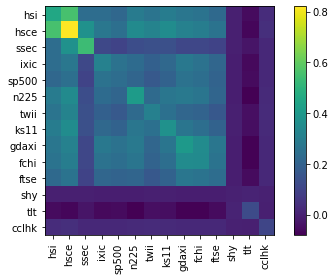

In [7]:
# 標準差
print(f'均方差 {start_year}年起      {df2.shape}')
draw_table(data=risk_models.sample_cov(df2).round(4), title='mean_square_error_2.png', scale_x=1.5, scale_y=1.5)
plotting.plot_covariance(risk_models.sample_cov(df2), plot_correlation=False, show_tickers=True, filename=os.path.join(temp_path, 'mean_square_error_1.png'))
risk_models.sample_cov(df2)

In [8]:
def simulate(df7):
    df7_1 = pd.DataFrame(columns=df7.columns)
    df7_1['Date'] = df7['Date']
    for v in df7.columns[1:]:
        cur_money = 10000
        no = 1
        for v1 in df7[v]:
            data2 = cur_money * (v1 / 100)
            cur_money = cur_money + data2
            df7_1.loc[no, v] = cur_money
            no = no + 1
    return df7_1

In [9]:
# inflation rate
cpi_data = {
    'hk': 'hk_cpi_1980',
    'china': 'china_cpi_1993',
    'us': 'us_cpi'
}
cpi = {}

for k, v in cpi_data.items():
    df8 = pd.read_csv(os.path.join(path_root, f'{v}.csv'))
    df8.Date = pd.to_datetime(df8.Date)
    df8.index = df8.Date
    df8.sort_index(inplace=True)
    
    #
    if k == 'china' or k == 'us':
        df8 = df8.groupby(df8['Date'].dt.year)['cpi'].agg(['sum', 'mean', 'max'])
        df8.columns = ['Date', 'cpi', 'max']
        del df8['max']
        df8.Date = [str(v2)+'-12-31' for v2 in df8.index.values]
    elif k == 'hk':
        df8.Date = df8.Date.dt.strftime('%Y-%m-%d')
    
    #
    no = 0
    for k1, v1 in df8.iterrows():
        if no < df8.shape[0] and no > 0:
            df8.loc[k1, 'Purchasing Power(%)'] = (df8.iloc[no-1].cpi - df8.iloc[no].cpi) / df8.iloc[no].cpi * 100
        no = no + 1
    df8['Inflation(%)'] = df8['cpi'].pct_change()*100
    df8.reset_index(drop=True, inplace=True)
    draw_table(data=df8.round(2), title=f'inflation_rate_{k}.png', scale_x=1.5, scale_y=1.5)
    cpi[k] = df8

inflation_rate_hk.png
inflation_rate_china.png
inflation_rate_us.png


<Figure size 432x288 with 0 Axes>

In [10]:
# 年度
df3_1 = df2.copy(deep=True)
df3 = pd.DataFrame(columns=['Date']+df3_1.columns.to_list())
for year in range(start_year, end_year, 1):
    df3_2 = df3_1[f'{year}-01-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df3.loc[df3.shape[0]+1] = [f'{year}-01-01 ~ {year}-12-31']+df3_2.iloc[-1].to_list()
    
# cpi
for k, df3_3 in cpi.items():
    df3_3.index = pd.to_datetime(df3_3.Date)
    df3_4 = df3_3[f'{start_year}-01-01': f'{end_year}-12-31']
    df3[f'{k}_cpi'] = df3_4['Purchasing Power(%)'].values

#
print(f'年度標準差 (每年遇到的風險/收益)  {start_year}年起')
df3_3 = pd.DataFrame(columns=['underlying', 'skewness', 'kurtosis', 'min', 'max', 'median', 'mean', 'sd'])
df3_3['underlying'] = df3.columns.values[1:]
df3_3['sd'] = df3.std().to_list()

df3_4 = df3.copy(deep=True)
del df3_4['Date']
stats3 = stats.describe(df3_4.values)
df3_3['min'] = stats3.minmax[0]
df3_3['max'] = stats3.minmax[1]
df3_3['mean'] = stats3.mean
df3_3['skewness'] = stats3.skewness
df3_3['kurtosis'] = stats3.kurtosis

df3_5 = df3_4.quantile([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).values.tolist()
df3_3['median'] = df3_5[5]

df3_3 = df3_3.sort_values(by=['sd'])
draw_table(data=df3_3.round(2), title=f'yearly_expected_return_stats.png', scale_x=1.5, scale_y=1.5, is_show=True)

#
print('年度收益率(回報)')
df3_2 = simulate(df3)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5.5), facecolor='white')
    
    ax1.barh(df3['Date'], df3[k], height=0.5, align='center')
    ax1.set_title(k+' Yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df3_2['Date'], df3_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_YearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax = df3.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
    # ax2 = df3_2.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
    
draw_table(data=df3.round(2), title=f'yearly_expected_return.png', scale_x=1.5, scale_y=1.5)
df3

年度標準差 (每年遇到的風險/收益)  2003年起
yearly_expected_return_stats.png
年度收益率(回報)


d:\pycharmprojects\scrapy-001\venv\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


yearly_expected_return.png


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,shy,tlt,cclhk,hk_cpi,china_cpi,us_cpi
1,2003-01-01 ~ 2003-12-31,28.950359,132.517439,12.118873,41.170184,19.426052,20.512135,23.775336,18.858271,25.195026,9.672707,11.398513,2.475207,4.759826,12.150838,2.808989,-1.115031,-2.246377
2,2004-01-01 ~ 2004-12-31,9.293958,-10.810046,-18.675262,3.931410,6.454176,2.570398,-2.277068,7.306155,4.352187,4.316449,4.825744,0.866281,10.321321,27.824825,0.225225,-3.683749,-2.598262
3,2005-01-01 ~ 2005-12-31,13.415259,16.091352,-9.876435,10.655650,8.263806,36.334592,11.434483,45.096472,27.327941,21.985286,15.112723,1.355295,3.511550,6.296992,-0.782123,-1.745408,-3.256231
4,2006-01-01 ~ 2006-12-31,24.107314,52.162751,85.736764,8.321218,12.554006,10.425724,19.471264,10.466840,23.342589,16.379023,10.360544,3.486413,1.381290,5.159793,-1.971522,-1.622667,-3.121512
5,2007-01-01 ~ 2007-12-31,28.039175,53.106558,66.261351,5.898221,1.612852,-12.479151,-0.148170,34.942526,17.019248,-1.163127,0.955228,6.816285,8.231305,34.454358,-2.038627,-4.595416,-2.790449
6,2008-01-01 ~ 2008-12-31,-47.282012,-49.984544,-65.689554,-39.574149,-38.608090,-39.676977,-43.981306,-38.967531,-39.813770,-42.585411,-31.824427,6.120375,33.175600,-20.882099,-4.115226,-5.593806,-3.674763
7,2009-01-01 ~ 2009-12-31,34.599261,40.642175,66.052344,37.445862,20.119687,12.610134,65.746182,40.104984,18.991601,15.242629,15.599613,1.164524,-16.819004,30.499304,-0.511771,0.733510,0.321387
8,2010-01-01 ~ 2010-12-31,6.847413,0.009964,-9.889940,13.710243,9.485518,-3.387213,6.441910,17.713747,16.220928,-3.027677,6.554188,2.024937,8.021119,15.659244,-2.300000,-3.077602,-1.610217
9,2011-01-01 ~ 2011-12-31,-24.080420,-22.779071,-17.712673,-7.153876,-6.622819,-19.806364,-25.866283,-14.659290,-19.766632,-26.257250,-9.739395,1.453811,40.272163,-1.976936,-5.033238,-5.261669,-3.044079
10,2012-01-01 ~ 2012-12-31,11.672378,1.332461,-5.457066,7.064879,8.937478,11.780100,3.022237,2.191126,18.007583,11.405428,4.251381,0.166030,4.194774,19.380745,-3.923358,-2.552658,-2.031083


<Figure size 432x288 with 0 Axes>

In [11]:
# 累計 年化收益率
df4_4 = pd.DataFrame(columns=df3.columns.to_list())

for i in range(1, df3.shape[0]):
    df4_3 = df3.copy(deep=True)
    df4_3 = df4_3.tail(i)
    df4 = pd.DataFrame(columns=df4_3.columns.to_list())
    
    # 年份
    start_year_4 = df4_3['Date'].iloc[0].split('~')[0].replace(' ', '')
    for k, v in df4_3.iterrows():
        end_year_4 = v['Date'].split('~')[1].replace(' ', '')
        df4_3.loc[k, 'Date'] = f'{start_year_4} ~ {end_year_4}'
    df4['Date'] = df4_3['Date']
    
    # 每產品
    for code in list(df4_3.columns.values)[1:]:
        annualized_total_return = 1
        annualized_total_returns = []
        # 每年
        for v in df4_3[code]:
            annualized_total_return = annualized_total_return * (1+(v/100))
            annualized_total_returns.append((annualized_total_return-1))
        df4[code] = annualized_total_returns

    for code in list(df4_3.columns.values)[1:]:
        df4[code] = df4[code]*100
        
    # 各x年 累計 年化收益率
    df4_4.loc[len(df4_4)] = df4.tail(1).values[0]
    
    # 繪圖
    no_year = df4.shape[0]
    draw_table(df4.round(2), f'annualized_return_nearly_{no_year}_years.png')

# 繪圖
df4_4.sort_values(by='Date', inplace=True)
draw_table(df4_4.round(2), f'annualized_return.png')
df4_4

annualized_return_nearly_1_years.png
annualized_return_nearly_2_years.png
annualized_return_nearly_3_years.png
annualized_return_nearly_4_years.png
annualized_return_nearly_5_years.png
annualized_return_nearly_6_years.png
annualized_return_nearly_7_years.png
annualized_return_nearly_8_years.png
annualized_return_nearly_9_years.png
annualized_return_nearly_10_years.png
annualized_return_nearly_11_years.png
annualized_return_nearly_12_years.png
annualized_return_nearly_13_years.png
annualized_return_nearly_14_years.png
annualized_return_nearly_15_years.png
annualized_return_nearly_16_years.png
annualized_return_nearly_17_years.png
annualized_return.png


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,shy,tlt,cclhk,hk_cpi,china_cpi,us_cpi
16,2004-01-01 ~ 2020-12-31,29.773962,6.635028,35.982790,387.747653,169.263699,131.410354,77.993769,205.580323,177.769034,19.223913,9.870624,38.045471,236.644427,269.314423,-34.074074,-36.095096,-28.914736
15,2005-01-01 ~ 2020-12-31,18.738459,19.559461,67.209627,369.297639,152.938597,125.611246,82.141250,184.774273,166.184200,14.290617,4.812635,36.859880,205.149019,188.922300,-34.222222,-33.650964,-27.018485
14,2006-01-01 ~ 2020-12-31,4.693548,2.987396,85.533747,324.106350,133.631724,65.483494,63.451424,96.265470,109.054037,-6.307867,-8.947828,35.029826,194.797073,171.806656,-33.703704,-32.472331,-24.562051
13,2007-01-01 ~ 2020-12-31,-15.642725,-32.317604,-0.109304,291.526569,107.572997,49.859551,36.812334,77.669127,69.490554,-19.493969,-17.495720,30.480730,190.780551,158.470132,-32.370370,-31.358508,-22.131373
12,2008-01-01 ~ 2020-12-31,-34.116043,-55.793928,-39.919473,269.719684,104.278291,71.227259,37.015349,31.662813,44.839893,-18.546562,-18.276367,22.154342,168.665846,92.236336,-30.962963,-28.052207,-19.896115
11,2009-01-01 ~ 2020-12-31,24.974338,-11.615176,75.108556,511.856812,232.744642,183.850595,144.588616,115.725851,140.652875,41.868887,19.872309,15.109225,101.738040,142.974516,-28.000000,-23.789118,-16.840189
10,2010-01-01 ~ 2020-12-31,-7.150799,-37.156245,5.453830,345.162045,177.010914,152.064876,47.568175,53.974431,102.243581,23.104521,3.696116,13.784181,142.529004,86.188361,-27.629630,-24.344061,-17.106598
9,2011-01-01 ~ 2020-12-31,-13.101124,-37.162506,17.027810,291.488077,153.011466,160.902187,38.637285,30.804120,74.016492,26.948099,-2.682271,11.525853,124.519989,60.980096,-25.925926,-21.941739,-15.749990
8,2012-01-01 ~ 2020-12-31,14.461744,-18.626344,42.218509,321.652579,170.956418,225.340265,87.009760,53.272828,116.887930,72.149938,7.818609,9.927712,60.060260,64.226753,-22.000000,-17.606463,-13.104832
7,2013-01-01 ~ 2020-12-31,2.497812,-19.696358,50.427434,293.829034,148.726539,191.053832,81.523684,49.986436,83.791519,54.525629,3.421756,9.745502,53.616399,37.565529,-18.814815,-15.448143,-11.303330


<Figure size 432x288 with 0 Axes>

In [12]:
print("每日收市價 标准差")
df2_1 = pd.DataFrame()
for ucode in ucodes:
    d1 = stats.describe(df2[ucode].values)
    d2 = np.std(df2[ucode].values)
    d3 = np.mean(df2[ucode].values)
    
    d4_1 = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    d4 = df2[ucode].quantile(d4_1).values.tolist()
    
    sd_map = [
        [0.318639, 0.25],
        [0.674490, 0.50],
        [1, 0.68268],
        [1.281552, 0.80],
        [2, 0.95449],
        [3, 0.99730]
    ]
    no_year = ((df2[ucode].index[-1] - df2[ucode].index[0])/np.timedelta64(1, 'Y'))
    content = f'{ucode} | '
    for v in sd_map:
        content = content+"{:.2f}年 ±{:.0f} {:.2f}% | ".format(no_year*v[1], d2*v[0], d2*v[0]/d3*100)
    print(content)
    
    df2_1 = df2_1.append(pd.Series([ucode, d1.skewness, d1.kurtosis, d2, "{:.3f}%".format(d2/d3*100), content]), ignore_index=True)
df2_1.columns=['标的', '偏态', '峰度', '标准差', '相对标准偏差', 'x年一遇±']
df2_1

每日收市價 标准差
hsi | 4.75年 ±1797 8.56% | 9.50年 ±3803 18.12% | 12.97年 ±5638 26.86% | 15.19年 ±7226 34.43% | 18.13年 ±11277 53.73% | 18.94年 ±16915 80.59% | 
hsce | 4.75年 ±1037 10.97% | 9.50年 ±2196 23.22% | 12.97年 ±3255 34.42% | 15.19年 ±4172 44.11% | 18.13年 ±6511 68.84% | 18.94年 ±9766 103.26% | 
ssec | 4.75年 ±287 11.03% | 9.50年 ±608 23.34% | 12.97年 ±901 34.61% | 15.19年 ±1155 44.35% | 18.13年 ±1802 69.21% | 18.94年 ±2703 103.82% | 
ixic | 4.75年 ±951 22.39% | 9.50年 ±2013 47.39% | 12.97年 ±2985 70.26% | 15.19年 ±3826 90.04% | 18.13年 ±5970 140.51% | 18.94年 ±8955 210.77% | 
sp500 | 4.75年 ±258 14.50% | 9.50年 ±546 30.70% | 12.97年 ±810 45.51% | 15.19年 ±1038 58.33% | 18.13年 ±1619 91.03% | 18.94年 ±2429 136.54% | 
n225 | 4.75年 ±1721 11.29% | 9.50年 ±3643 23.90% | 12.97年 ±5401 35.43% | 15.19年 ±6922 45.41% | 18.13年 ±10802 70.86% | 18.94年 ±16204 106.29% | 
twii | 4.75年 ±796 9.50% | 9.50年 ±1685 20.11% | 12.97年 ±2499 29.81% | 15.19年 ±3202 38.20% | 18.13年 ±4997 59.62% | 18.94年 ±7496 89.43% | 
ks11 | 4.75年 ±183 10.48%

,标的,偏态,峰度,标准差,相对标准偏差,x年一遇±
0,hsi,-0.413210,-0.608249,5638.426621,26.863%,hsi | 4.75年 ±1797 8.56% | 9.50年 ±3803 18.12% |...
1,hsce,-0.579839,0.237142,3255.427297,34.420%,hsce | 4.75年 ±1037 10.97% | 9.50年 ±2196 23.22%...
2,ssec,0.472028,0.527003,901.137918,34.605%,ssec | 4.75年 ±287 11.03% | 9.50年 ±608 23.34% |...
3,ixic,1.542016,1.968327,2985.118205,70.257%,ixic | 4.75年 ±951 22.39% | 9.50年 ±2013 47.39% ...
4,sp500,1.099733,0.569909,809.567293,45.513%,sp500 | 4.75年 ±258 14.50% | 9.50年 ±546 30.70% ...
5,n225,0.537113,-0.532277,5401.172956,35.431%,n225 | 4.75年 ±1721 11.29% | 9.50年 ±3643 23.90%...
6,twii,1.128570,2.323946,2498.681534,29.809%,twii | 4.75年 ±796 9.50% | 9.50年 ±1685 20.11% |...
7,ks11,-0.162169,-0.017017,573.500192,32.899%,ks11 | 4.75年 ±183 10.48% | 9.50年 ±387 22.19% |...
8,gdaxi,0.283297,-1.053610,3340.480661,41.216%,gdaxi | 4.75年 ±1064 13.13% | 9.50年 ±2253 27.80...
9,fchi,0.113162,-0.876855,906.041182,20.561%,fchi | 4.75年 ±289 6.55% | 9.50年 ±611 13.87% | ...


In [13]:
print("年度收益率 标准差 (不同時机買入持有, 收益的差距有多大)")
df2_2 = pd.DataFrame()
for ucode in ucodes:
    d1 = stats.describe(df3[ucode].values)
    d2 = np.std(df3[ucode].values)
    d3 = np.mean(df3[ucode].values)
    
    d4_1 = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    d4 = df3[ucode].quantile(d4_1).values.tolist()
    
    sd_map = [
        [0.318639, 0.25],
        [0.674490, 0.50],
        [1, 0.68268],
        [1.281552, 0.80],
        [2, 0.95449],
        [3, 0.99730]
    ]
    no_year = df3.shape[0]
    content = f'{ucode} | '
    for v in sd_map:
        content = content+"{:.2f}年 ±{:.2f}% | ".format(no_year*v[1], d2*v[0])
    print(content)
    
    df2_2 = df2_2.append(pd.Series([ucode, d1.skewness, d1.kurtosis, d2, content]), ignore_index=True)
df2_2.columns=['标的', '偏态', '峰度', '标准差', 'x年一遇±']
df2_2 = df2_2.sort_values(by=['标准差', '偏态', '峰度'])
df2_2

年度收益率 标准差 (不同時机買入持有, 收益的差距有多大)
hsi | 4.50年 ±6.51% | 9.00年 ±13.77% | 12.29年 ±20.42% | 14.40年 ±26.17% | 17.18年 ±40.84% | 17.95年 ±61.26% | 
hsce | 4.50年 ±12.49% | 9.00年 ±26.44% | 12.29年 ±39.20% | 14.40年 ±50.24% | 17.18年 ±78.40% | 17.95年 ±117.61% | 
ssec | 4.50年 ±11.73% | 9.00年 ±24.82% | 12.29年 ±36.80% | 14.40年 ±47.16% | 17.18年 ±73.60% | 17.95年 ±110.41% | 
ixic | 4.50年 ±6.28% | 9.00年 ±13.28% | 12.29年 ±19.70% | 14.40年 ±25.24% | 17.18年 ±39.39% | 17.95年 ±59.09% | 
sp500 | 4.50年 ±4.75% | 9.00年 ±10.04% | 12.29年 ±14.89% | 14.40年 ±19.08% | 17.18年 ±29.78% | 17.95年 ±44.67% | 
n225 | 4.50年 ±6.45% | 9.00年 ±13.65% | 12.29年 ±20.24% | 14.40年 ±25.94% | 17.18年 ±40.48% | 17.95年 ±60.73% | 
twii | 4.50年 ±7.15% | 9.00年 ±15.14% | 12.29年 ±22.44% | 14.40年 ±28.76% | 17.18年 ±44.88% | 17.95年 ±67.32% | 
ks11 | 4.50年 ±6.49% | 9.00年 ±13.73% | 12.29年 ±20.36% | 14.40年 ±26.09% | 17.18年 ±40.72% | 17.95年 ±61.07% | 
gdaxi | 4.50年 ±5.68% | 9.00年 ±12.02% | 12.29年 ±17.82% | 14.40年 ±22.84% | 17.18年 ±35.64% | 17.95年 ±53.46% | 
f

,标的,偏态,峰度,标准差,x年一遇±
11,shy,1.305643,0.786539,1.912747,shy | 4.50年 ±0.61% | 9.00年 ±1.29% | 12.29年 ±1....
10,ftse,-1.125201,0.726916,12.387876,ftse | 4.50年 ±3.95% | 9.00年 ±8.36% | 12.29年 ±1...
13,cclhk,0.080528,0.025341,13.131848,cclhk | 4.50年 ±4.18% | 9.00年 ±8.86% | 12.29年 ±...
12,tlt,0.637614,0.253506,13.777958,tlt | 4.50年 ±4.39% | 9.00年 ±9.29% | 12.29年 ±13...
4,sp500,-1.572737,2.800770,14.891657,sp500 | 4.50年 ±4.75% | 9.00年 ±10.04% | 12.29年 ...
9,fchi,-1.160915,0.947342,16.875011,fchi | 4.50年 ±5.38% | 9.00年 ±11.38% | 12.29年 ±...
8,gdaxi,-1.395525,1.067607,17.818728,gdaxi | 4.50年 ±5.68% | 9.00年 ±12.02% | 12.29年 ...
3,ixic,-0.701173,0.707267,19.695361,ixic | 4.50年 ±6.28% | 9.00年 ±13.28% | 12.29年 ±...
5,n225,-0.132200,0.682019,20.242092,n225 | 4.50年 ±6.45% | 9.00年 ±13.65% | 12.29年 ±...
7,ks11,-0.328095,0.061591,20.358240,ks11 | 4.50年 ±6.49% | 9.00年 ±13.73% | 12.29年 ±...


In [14]:
# 半年度
df5_1 = df2.copy(deep=True)
df5 = pd.DataFrame(columns=['Date']+df5_1.columns.to_list())
for year in range(start_year, 2022, 1):
    # 上半年
    df5_2 = df5_1[f'{year}-01-01': f'{year}-06-30'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-01-01 ~ {year}-06-30']+df5_2.iloc[-1].to_list()
    # 下半年
    df5_2 = df5_1[f'{year}-07-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-07-01 ~ {year}-12-31']+df5_2.iloc[-1].to_list()
print(f'半年度標準差(風險)  {start_year}年起')
print(df5.std())

df5_2 = simulate(df5)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10), facecolor='white')
    
    ax1.barh(df5['Date'], df5[k], height=0.5, align='center')
    ax1.set_title(k+' Semi yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df5_2['Date'], df5_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Semi yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_SemiYearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df5.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
    # ax2 = df5_2.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
print('半年度收益率(回報)')
df5

半年度標準差(風險)  2003年起
hsi      13.056649
hsce     19.954315
ssec     21.478089
ixic     11.183645
sp500     9.609296
n225     12.908232
twii     13.080420
ks11     12.316979
gdaxi    12.316106
fchi     12.058834
ftse      8.683900
shy       1.208627
tlt      10.606401
cclhk     9.262728
dtype: float64
半年度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,shy,tlt,cclhk
1,2003-01-01 ~ 2003-06-30,-0.919100,33.149866,11.339438,14.175563,4.896609,4.243846,3.886880,0.482964,2.005862,-3.930197,0.744741,1.625280,9.527639,-7.234637
2,2003-07-01 ~ 2003-12-31,25.998641,71.554584,-0.336801,16.607681,10.459768,7.202128,9.068144,12.516155,18.598080,10.640474,9.391871,0.919326,-2.093090,19.529622
3,2004-01-01 ~ 2004-06-30,-6.233832,-20.479922,-11.679258,-1.345149,0.991785,9.781737,-6.784517,-6.449456,0.828816,4.525413,0.119655,-0.343712,-0.348352,19.937092
4,2004-07-01 ~ 2004-12-31,16.594444,13.260094,-8.709812,9.857405,7.205999,-4.134422,3.945300,18.497323,8.175962,3.078356,8.511470,0.488957,7.365476,8.502773
5,2005-01-01 ~ 2005-06-30,5.894154,6.318927,-10.442695,1.817096,2.314925,1.105365,9.209237,7.366403,7.661545,8.027890,4.800000,0.886043,7.649887,11.296992
6,2005-07-01 ~ 2005-12-31,7.244699,8.777004,11.888489,4.088641,3.319565,31.835180,2.104509,28.735230,14.727522,8.638080,5.672972,0.780734,-2.128946,-3.366370
7,2006-01-01 ~ 2006-06-30,2.198804,4.609132,30.075070,-5.105696,-1.049191,-1.355737,2.220474,-4.576740,3.101857,1.041669,0.358605,0.381368,-8.137189,3.874308
8,2006-07-01 ~ 2006-12-31,17.555642,36.013121,37.421719,11.191416,11.114760,8.929638,13.486949,10.707471,15.484125,11.036772,6.168853,2.824136,9.081978,0.666553
9,2007-01-01 ~ 2007-06-30,5.055448,19.777412,34.361604,6.005998,5.255985,3.806783,13.984375,28.921596,18.591927,7.582204,5.950084,1.890822,-2.666032,8.167467
10,2007-07-01 ~ 2007-12-31,16.562560,18.173233,25.585627,-3.579002,-5.610860,-16.494325,-16.424939,-2.323755,-3.119203,-9.661148,-6.478770,4.779259,11.351928,23.967727


<Figure size 432x288 with 0 Axes>

In [15]:
# 季度
df7_1 = df2.copy(deep=True)
df7 = pd.DataFrame(columns=['Date']+df7_1.columns.to_list())
quarterly = [['01-01', '03-31'], ['04-01', '06-30'], ['07-01', '09-30'], ['10-01', '12-31']]
for year in range(start_year, 2022, 1):
    for v in quarterly:
        first = v[0]
        last = v[1]
        if df7_1[f'{year}-{first}': f'{year}-{last}'].shape[0]>0:
            df7_2 = df7_1[f'{year}-{first}': f'{year}-{last}'].iloc[[0, -1]].pct_change()*100
            df7.loc[df7.shape[0]+1] = [f'{year}-{first} ~ {year}-{last}']+df7_2.iloc[-1].to_list()
print(f'季度標準差(風險)  {start_year}年起')
print(df7.std())

df7_2 = simulate(df7)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 20), facecolor='white')
    
    ax1.barh(df7['Date'], df7[k], height=0.5, align='center')
    ax1.set_title(k+' Quarterly Expected Return')
    ax1.grid()
    
    ax2.barh(df7_2['Date'], df7_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Quarterly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_QuarterlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df7.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)
    # ax2 = df7_2.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)

print('季度收益率(回報)')
df7

季度標準差(風險)  2003年起
hsi       8.186186
hsce     11.223497
ssec     13.176479
ixic      7.064246
sp500     6.545658
n225      8.829635
twii      8.040986
ks11      8.447127
gdaxi     9.720732
fchi      8.844707
ftse      6.769201
shy       0.727841
tlt       6.670059
cclhk     4.873067
dtype: float64
季度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,shy,tlt,cclhk
1,2003-01-01 ~ 2003-03-31,-10.671571,6.807838,13.179128,-5.639118,-8.700662,-8.499851,-7.860363,-19.650224,-23.228439,-18.434900,-9.699102,0.927114,3.824414,-5.391061
2,2003-04-01 ~ 2003-06-30,6.861144,23.937078,-1.921147,16.789374,10.747447,10.098568,6.475753,14.342032,14.654644,5.055734,2.423901,0.848352,7.524096,-0.806452
3,2003-07-01 ~ 2003-09-30,12.624639,13.846892,-9.733640,6.035305,0.215053,4.434947,6.035781,-1.168550,-0.284747,0.204891,1.666343,0.274410,-2.725355,9.645728
4,2003-10-01 ~ 2003-12-31,2.604571,26.211987,10.072023,4.225145,6.202849,-5.922837,-4.491691,2.060687,11.052358,4.822853,2.527829,0.958040,3.770792,5.132234
5,2004-01-01 ~ 2004-03-31,-4.444257,-15.176173,9.648397,-2.676131,0.022277,8.249943,5.692496,6.136392,-3.831857,0.717511,-2.361900,1.061080,6.755359,16.961045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2020-07-01 ~ 2020-09-30,-10.870162,-12.524014,-3.460855,6.554560,5.405511,3.509572,2.856055,5.491499,1.079204,-4.688365,-5.695286,0.091300,1.288565,-3.421955
72,2020-10-01 ~ 2020-12-31,6.722197,5.295107,1.849178,7.294045,4.546971,13.395187,11.030100,15.597423,0.821177,8.315439,6.913385,0.039373,-1.965902,-0.989088
73,2021-01-01 ~ 2021-03-31,3.150349,2.051198,-1.931454,2.844443,7.307908,7.799945,10.561919,3.110601,7.947841,7.632007,2.500043,-0.067167,-13.786781,-0.358949
74,2021-04-01 ~ 2021-06-30,2.864415,-0.103542,5.667238,4.696821,3.939448,-1.661246,4.337393,5.303621,2.229245,6.432334,2.669433,-0.053390,4.683323,1.343369


<Figure size 432x288 with 0 Axes>

In [16]:
df6 = df2.copy(deep=True)

expected_return = expected_returns.mean_historical_return(df6)
cov_matrix1 = risk_models.CovarianceShrinkage(df6).ledoit_wolf()
cov_matrix2 = risk_models.sample_cov(df6)

sector_mapper = {
    "03033": "no_stock",
    "hsi": "stock",
    "02800": "no_stock",
    "efedfaa": "no_stock",
    "cuischi": "no_stock",
    "hsce": "no_stock",
    "ssec": "stock",
    "xin9x000": "no_stock",
    "02823": "no_stock",
    "sp500": "no_stock",
    "ixic": "stock",
    "qqq": "no_stock",
    "chsfiih": "low_bond",
    "chasaau": "high_bond",
    "shy": "low_bond",
    "tlt": "high_bond"
}

columns6 = ['Strategy', 'Expected annual return', 'Annual volatility', 'Sharpe ratio']
df6_1 = pd.DataFrame(columns=columns6)
for i in range(0, 105, 5):
    val = i/100
    
    sector_lower = {}
    sector_upper = {}
    # sector_upper = {'stock': val, 'no': 0, 'high_bond': 0}
    ef = efficient_frontier.EfficientFrontier(expected_return, cov_matrix2, weight_bounds=(0,1), verbose=False)
    ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

    title = f'{str(i).zfill(2)}/{str(100-i).zfill(2)} Strategy'
    """
    fig, ax = plt.subplots()
    ax.set_title(f"Efficient Frontier {title}")
    plotting.plot_efficient_frontier(ef, ax=ax)
    plt.show()
    """

    ef.add_objective(objective_functions.L2_reg)
    ef.min_volatility()

    weights = ef.clean_weights()
    weights2 = json.dumps(weights).replace('"', '').replace('{', '').replace('}', '')
    print(title, weights2)
    # ef.save_weights_to_file("weights.txt")
    # pd.Series(weights).plot.barh()
    
    ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=False)
    df6_1.loc[len(df6_1)] = [title, "{:.3f}%".format(ret_tangent*100), "{:.3f}%".format(std_tangent*100), "{:.2f}".format(_)]
df6_1

00/100 Strategy hsi: 0.03063, hsce: 0.00085, ssec: 0.07131, ixic: 0.05398, sp500: 0.06482, n225: 0.04792, twii: 0.05896, ks11: 0.04596, gdaxi: 0.03886, fchi: 0.04613, ftse: 0.06541, shy: 0.16565, tlt: 0.17187, cclhk: 0.13764
05/95 Strategy hsi: 0.03063, hsce: 0.00085, ssec: 0.07131, ixic: 0.05398, sp500: 0.06482, n225: 0.04792, twii: 0.05896, ks11: 0.04596, gdaxi: 0.03886, fchi: 0.04613, ftse: 0.06541, shy: 0.16565, tlt: 0.17187, cclhk: 0.13764
10/90 Strategy hsi: 0.03063, hsce: 0.00085, ssec: 0.07131, ixic: 0.05398, sp500: 0.06482, n225: 0.04792, twii: 0.05896, ks11: 0.04596, gdaxi: 0.03886, fchi: 0.04613, ftse: 0.06541, shy: 0.16565, tlt: 0.17187, cclhk: 0.13764
15/85 Strategy hsi: 0.03063, hsce: 0.00085, ssec: 0.07131, ixic: 0.05398, sp500: 0.06482, n225: 0.04792, twii: 0.05896, ks11: 0.04596, gdaxi: 0.03886, fchi: 0.04613, ftse: 0.06541, shy: 0.16565, tlt: 0.17187, cclhk: 0.13764
20/80 Strategy hsi: 0.03063, hsce: 0.00085, ssec: 0.07131, ixic: 0.05398, sp500: 0.06482, n225: 0.04792

,Strategy,Expected annual return,Annual volatility,Sharpe ratio
0,00/100 Strategy,64.242%,24.432%,2.55
1,05/95 Strategy,64.242%,24.432%,2.55
2,10/90 Strategy,64.242%,24.432%,2.55
3,15/85 Strategy,64.242%,24.432%,2.55
4,20/80 Strategy,64.242%,24.432%,2.55
5,25/75 Strategy,64.242%,24.432%,2.55
6,30/70 Strategy,64.242%,24.432%,2.55
7,35/65 Strategy,64.242%,24.432%,2.55
8,40/60 Strategy,64.242%,24.432%,2.55
9,45/55 Strategy,64.242%,24.432%,2.55
